In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import random
import numpy as np
import os

os.chdir("/home/jovyan/DL_Project02")
#os.listdir()

In [22]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CKPT_PATH = "./ResNet_Models/resnet101_gtsrb_best.pt"
NUM_CLASSES = 43
DATA_ROOT = "./data_gtsrb"
IMG_SIZE = 224
NUM_WORKERS = 2

SUBSET_SIZE = 120   # small & stable
BATCH_SIZE = 4

#STOP_CLASS = 14
TARGET = 9
PATCH_SIZE = 40
EPOCHS = 20
LR = 0.03


print("Device:", DEVICE)

Device: cuda


In [23]:

weights = models.ResNet101_Weights.IMAGENET1K_V2
model = models.resnet101(weights=weights)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

ckpt = torch.load(CKPT_PATH, map_location=DEVICE)

# Robust: checkpoint might be {"model_state": ...} or directly a state_dict
state_dict = ckpt["model_state"] if isinstance(ckpt, dict) and "model_state" in ckpt else ckpt
model.load_state_dict(state_dict)

model.to(DEVICE).eval();

In [24]:
class UniversalTargetedPatchTrainer:
    def __init__(
        self,
        model,
        target_class,
        patch_size,
        lr,
        init_patch=None,
        clamp_min=-2.5,
        clamp_max=2.5
    ):
        self.model = model
        self.target_class = target_class
        self.patch_size = patch_size
        self.device = DEVICE
        self.clamp_min = clamp_min
        self.clamp_max = clamp_max

        # ---- PATCH INITIALIZATION ----
        if init_patch is not None:
            assert init_patch.shape == (3, patch_size, patch_size), \
                f"Expected patch shape (3,{patch_size},{patch_size})"

            self.patch = init_patch.to(self.device).clone()
            self.patch.requires_grad_(True)
            print("Loaded existing patch")

        else:
            self.patch = torch.rand(
                3, patch_size, patch_size,
                device=self.device,
                requires_grad=True
            )
            print("Initialized new random patch")

        # ---- OPTIMIZER ----
        self.optimizer = optim.Adam([self.patch], lr=lr)
        self.criterion = nn.CrossEntropyLoss()

    def apply_patch(self, images, random_pos=True):
        B, C, H, W = images.shape
        patched = images.clone()

        for i in range(B):
            if random_pos:
                x = random.randint(0, W - self.patch_size)
                y = random.randint(0, H - self.patch_size)
            else:
                x = (W - self.patch_size) // 2
                y = (H - self.patch_size) // 2

            patched[i, :, y:y+self.patch_size, x:x+self.patch_size] = self.patch

        return patched.clamp(self.clamp_min, self.clamp_max)

    def train_on_batch(self, images):
        images = images.to(self.device)

        patched = self.apply_patch(images)
        outputs = self.model(patched)

        targets = torch.full(
            (images.size(0),),
            self.target_class,
            device=self.device,
            dtype=torch.long
        )

        loss = self.criterion(outputs, targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # keep patch bounded
        self.patch.data.clamp_(self.clamp_min, self.clamp_max)

        return loss.item()


In [25]:
def remove_target_class(dataset, target_class):
    indices = [i for i, (_, y) in enumerate(dataset) if y != target_class]
    return Subset(dataset, indices)


BATCH_SIZE = 4
SUBSET_SIZE = 300   # small & stable

imagenet_mean = (0.485, 0.1, 0.106)
imagenet_std  = (0.229, 0.224, 0.225)

tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    #transforms.Normalize(imagenet_mean, imagenet_std),
])

test_set = datasets.GTSRB(
    root=DATA_ROOT,
    split="test",
    download=True,
    transform=tfms
)

indices = random.sample(range(len(test_set)), SUBSET_SIZE)
patch_test_set = Subset(test_set, indices)
#print(len(indices))
patch_train_set = remove_target_class(patch_test_set, TARGET)
print(len(patch_train_set))
Patch_loader = DataLoader(
    patch_train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

indices = random.sample(range(len(test_set)), 6000)
small_test_set = Subset(test_set, indices)

test_loader = DataLoader(
    small_test_set,
    batch_size=50,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)


289


Target Sign 9 : Prediction: 9


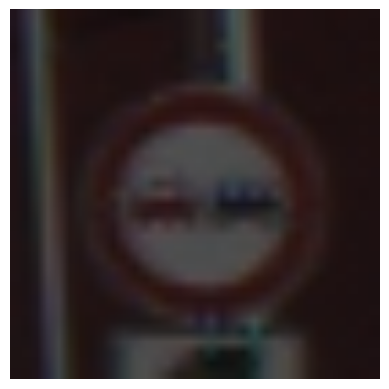

In [26]:
# Check target prediction if is true.

for images, labels in test_loader:
    idx = (labels == TARGET).nonzero(as_tuple=True)[0]
    if len(idx) > 0:
        img = images[idx[0]:idx[0]+1].to(DEVICE)
        img_v=images[idx[0]]
        lbl=labels[idx[0]]
        break

with torch.no_grad():
    print("Target Sign",lbl.item(),":", "Prediction:",model(img).argmax(1).item())



img_v = img_v.detach().cpu()
img = img_v.permute(1,2,0).clamp(0,1)
plt.imshow(img)
plt.axis('off')
plt.show()

In [32]:
#from attacks.adv_patch_trainer import UniversalTargetedPatchTrainer
PATCH_SIZE = 40
EPOCHS = 50
LR = 0.3
BATCH_LIMIT=150

model.eval()
for p in model.parameters():
    p.requires_grad = False



    
trainer = UniversalTargetedPatchTrainer(
    model=model,
    target_class=TARGET,
    patch_size=PATCH_SIZE,
    lr=LR,
    init_patch=torch.load(f"./Patches/Target_9_patch_SRT9351_MR9502.pt")
)

# #for epoch in range(EPOCHS):
# epoch=0; 
# while epoch<EPOCHS:
#     total_loss = 0
#     batches = 0

#     for  i, (images, _) in enumerate (Patch_loader):
#         images = images[:4]  # very important for GPU stability
#         loss = trainer.train_on_batch(images)
#         total_loss += loss
#         batches += 1
#         if i >= BATCH_LIMIT:
#             break
#     avg_loss=total_loss / batches
#     print(f"Epoch {epoch+1}: avg loss = {avg_loss:.4f}")
#     if avg_loss<0.15:
#         break
#     epoch+=1
    
# torch.save(trainer.patch.detach().cpu(), f"./Patches/Target_{TARGET}_patch.pt")

Loaded existing patch


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.5..2.5].


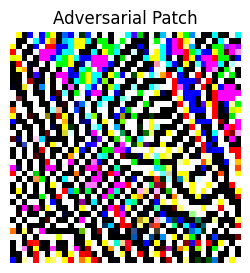

In [28]:
#patch = trainer.patch.detach().cpu()
#patch = torch.load(f"./Patches/Target_{TARGET}_patch.pt")
patch = torch.load(f"./Patches/Target_9_patch_SRT9351_MR9502.pt")
# Convert from (C, H, W) → (H, W, C)
patch = patch.permute(1, 2, 0)

plt.figure(figsize=(3, 3))
plt.imshow(patch)
plt.axis("off")
plt.title("Adversarial Patch")
plt.show()


In [33]:
def targeted_attack_success_rate(model, loader, trainer, target_class):
    model.eval()
    success = 0
    wrong = 0
    total = 0

    for images, labels in loader:
        
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # Exclude the Target images
        mask = labels != target_class
        if mask.sum() == 0:
            continue

        images = images[mask]
        labels = labels[mask]
        
        patched = trainer.apply_patch(images)

        with torch.no_grad():
            preds = model(patched).argmax(dim=1)
            
        wrong += (preds != labels).sum().item()
        success += (preds == target_class).sum().item()
        total += images.size(0)

    return success / total, wrong/total

rate,mis_rate = targeted_attack_success_rate(model, test_loader, trainer, TARGET)

print(f"Targeted Attack Success Rate Target {TARGET}: {rate*100:.2f}%")
print(f"Misclassification Rate: {mis_rate*100:.2f}%")


Targeted Attack Success Rate Target 9: 92.83%
Misclassification Rate: 94.55%


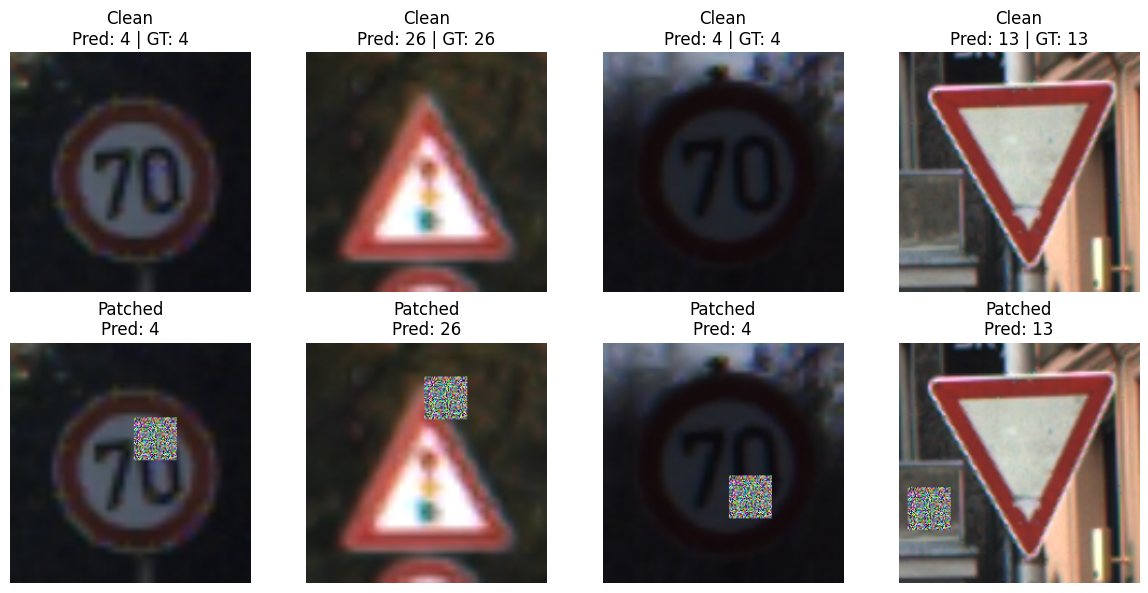

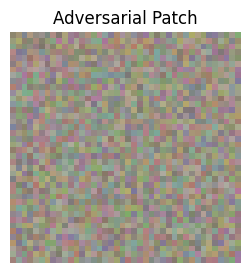

In [ ]:
def denormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406], device=img.device).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225], device=img.device).view(3,1,1)
    return img * std + mean

# images, labels = next(iter(test_loader))
# images = images[:4].to(DEVICE)
# labels = labels[:4]

# patched = trainer.apply_patch(images)

with torch.no_grad():
    images, labels = next(iter(test_loader))
    images = images[:4].to(DEVICE)
    labels = labels[:4]

    patched = trainer.apply_patch(images)
    clean_preds = model(images).argmax(1)
    patch_preds = model(patched).argmax(1)

plt.figure(figsize=(12,6))

for i in range(4):
    # ----- CLEAN IMAGE -----
    plt.subplot(2,4,i+1)
    clean_img = images[i].detach().cpu()
    #clean_img = denormalize(images[i]).detach().cpu()
    clean_img = clean_img.permute(1,2,0).clamp(0,1)
    plt.imshow(clean_img)
    plt.title(f"Clean\nPred: {clean_preds[i].item()} | GT: {labels[i].item()}")
    plt.axis("off")

    # ----- PATCHED IMAGE -----
    plt.subplot(2,4,i+5)
    patched_img = patched[i].detach().cpu()
    patched_img = patched_img.permute(1,2,0).clamp(0,1)
    plt.imshow(patched_img)
    plt.title(f"Patched\nPred: {patch_preds[i].item()}")
    plt.axis("off")

plt.tight_layout()
plt.show()

patch = denormalize(trainer.patch).detach().cpu()

# Convert from (C, H, W) → (H, W, C)
patch = patch.permute(1, 2, 0)

plt.figure(figsize=(3, 3))
plt.imshow(patch)
plt.axis("off")
plt.title("Adversarial Patch")
plt.show()